In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.lines import Line2D

from Mytorch.utils.augmentation import Augmentation
from Mytorch import nn, optim, tensor, loss
from Mytorch.nn.sequential import Sequential
from Mytorch.nn.linear import Linear
from Mytorch.nn.conv2d import Conv2d
from Mytorch.nn.maxpool import Maxpool
from Mytorch.nn.activation_function import *
from Mytorch.loss.lossFunction import CrossEntropy, MSE
from Mytorch.evaluator.performance import ClassificationPerformance
from Mytorch.optim.sgd import SGD

## 定义准确率函数

In [2]:
def accuracy(a, y):
    size = a.shape[0]
    idx_a = np.argmax(a, axis=1)
    idx_y = np.argmax(y, axis=1)
    acc = sum(idx_a == idx_y)
    return acc

## 加载数据

In [3]:
train_images = np.load('dataset/train_x.npy').transpose()
train_labels = np.load('dataset/train_y.npy').transpose()
test_images = np.load('dataset/test_x.npy').transpose()
test_labels = np.load('dataset/test_y.npy').transpose()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_aug = Augmentation(train_images)
train_aug.work()
train_images = np.concatenate((train_images, train_aug.img))
train_labels = np.concatenate((train_labels, train_labels))

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(40000, 784)
(40000, 10)
(5000, 784)
(5000, 10)


## 定义网络结构

In [4]:
# 初始化各层及激活函数
conv1 = Conv2d("conv1",intputChannal=1,outputChnnal=3,stride=1,padding=1,kernel_size=(3,3))
f1 = Relu("f1")
maxpool1 = Maxpool("maxpoo1", size = 2, stride = 2)
conv2 = Conv2d("conv2",intputChannal=3,outputChnnal=6,stride=1,padding=1,kernel_size=(3,3)) 
f2 = Relu("f2")
maxpool2 =Maxpool("maxpoo2", size = 2, stride = 2)
linear1 = Linear("linear1", 7 * 7 * 6, 128) 
f3 = Relu("f3")
linear2 = Linear("linear2", 128, 10)
f4 = SoftMax("f4")


# 构建网络
model = Sequential("model")
model.add_module(conv1)
model.add_module(maxpool1)
model.add_module(f1)
model.add_module(conv2)
model.add_module(maxpool2)
model.add_module(f2)
model.add_module(linear1)
model.add_module(f3)
model.add_module(linear2)
model.add_module(f4)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei




**********************************
network: odict_keys(['conv1', 'maxpoo1', 'f1', 'conv2', 'maxpoo2', 'f2', 'linear1', 'f3', 'linear2', 'f4'])
w_dict: odict_keys(['conv1', 'conv2', 'linear1', 'linear2'])
b_dict: odict_keys(['conv1', 'conv2', 'linear1', 'linear2'])
z_dict: odict_keys(['f1', 'f2', 'f3', 'f4'])
a_dict: odict_keys(['f1', 'f2', 'f3', 'f4'])
**********************************




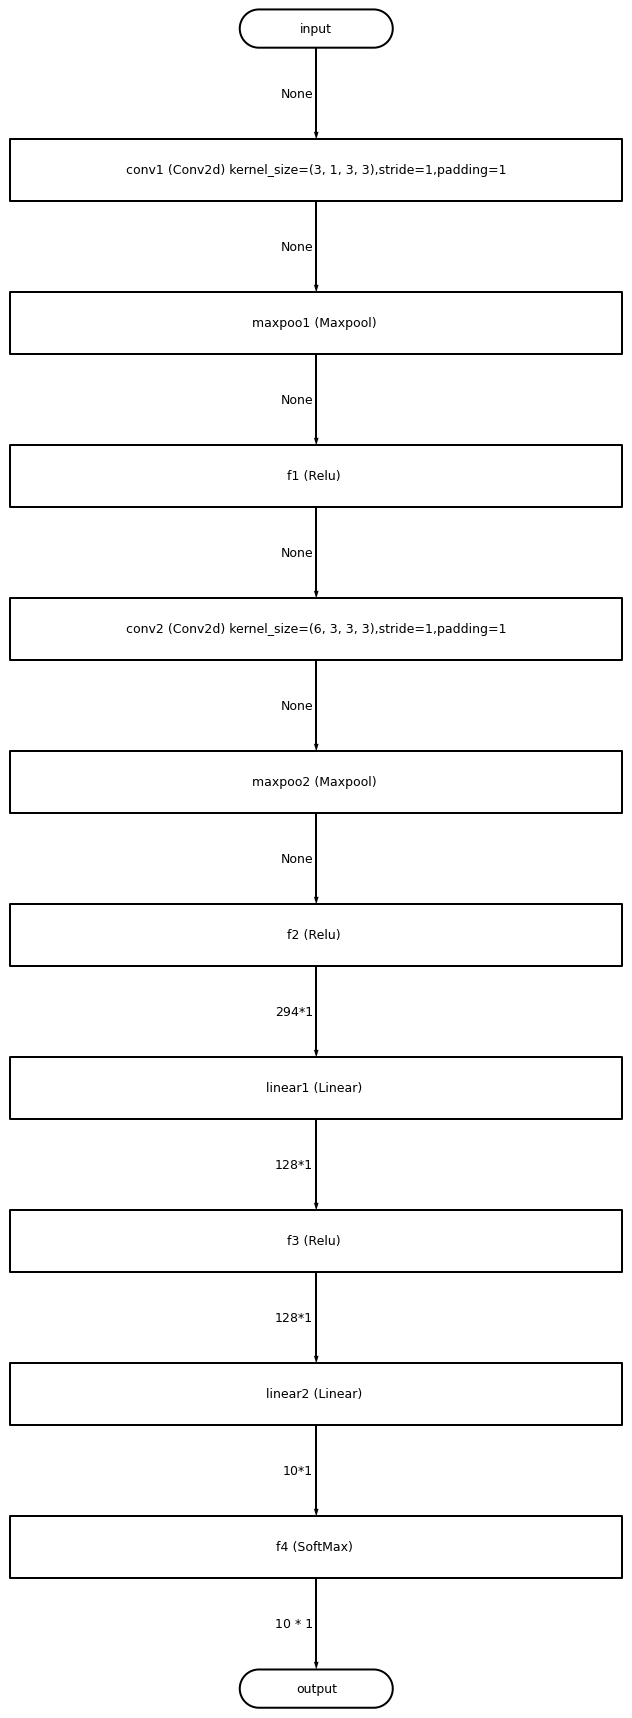

In [5]:
# 可视化网络结构
model.show()

## 训练

In [6]:
optimizer = SGD(model, lr=0.005)
criterion = CrossEntropy()

E_list = []
train_Loss_list = []
train_acc_list = []
test_Loss_list = []
test_acc_list = []
batch_size = 128
max_epoch = 20
for epoch in range(max_epoch):
    E_list.append(epoch)
    
    model.train()
    sample_idxs = np.random.permutation(train_images.shape[0])
    num_batch = int(np.ceil(train_images.shape[0]/batch_size))
    train_cost = 0
    acc = 0
    for batch_idx in range(num_batch):
        x = Tensor(train_images[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),train_images.shape[0])],:])
        y = Tensor(train_labels[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),train_labels.shape[0])],:])
        x = x.reshape((x.shape[0],1,28,28))
        y_pred = model(x)
        y_pre = y_pred.datas
        acc += accuracy(y, y_pre)
        optimizer.zero_grad()
        loss = criterion(y_pred,y)
        train_cost += loss.datas 
        loss.backward()
        optimizer.step()
    
    train_cost /= train_images.shape[0]
    acc /= train_images.shape[0]
    train_Loss_list.append(train_cost) 
    train_acc_list.append(acc)


    model.eval()
    sample_idxs = np.random.permutation(test_images.shape[0])
    num_batch = int(np.ceil(test_images.shape[0]/batch_size))
    acc = 0
    test_cost = 0
    for batch_idx in range(num_batch):
            x = Tensor(test_images[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_images.shape[0])],:])
            y = Tensor(test_labels[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_labels.shape[0])],:])
            x = x.reshape((x.shape[0],1,28,28))
            y_pre = model(x)
            loss = criterion(y_pre ,y)
            test_cost += loss.datas
            y_pre = y_pre.datas
            acc += accuracy(y, y_pre)
    acc /= test_labels.shape[0]
    test_cost /= test_images.shape[0]
    test_Loss_list.append(test_cost) 
    test_acc_list.append(acc)
    print("epoch= ",epoch," train cost = ",train_Loss_list[-1],"acc on traintset = ",train_acc_list[-1], "\ntest cost = ",test_Loss_list[-1],"acc on testtset = ",test_acc_list[-1])

epoch=  0  train cost =  1.0871531097261726 acc on traintset =  0.595975 
test cost =  0.5502370095123608 acc on testtset =  0.8038
epoch=  1  train cost =  0.5194554671812504 acc on traintset =  0.806575 
test cost =  0.4635467662340186 acc on testtset =  0.8294
epoch=  2  train cost =  0.44014413924136453 acc on traintset =  0.833825 
test cost =  0.44655293946152197 acc on testtset =  0.8362
epoch=  3  train cost =  0.4000096772743544 acc on traintset =  0.8487 
test cost =  0.4181193492282699 acc on testtset =  0.8508
epoch=  4  train cost =  0.37181853350140726 acc on traintset =  0.859575 
test cost =  0.4274164157475051 acc on testtset =  0.8484
epoch=  5  train cost =  0.351175719555985 acc on traintset =  0.8674 
test cost =  0.42725454228338977 acc on testtset =  0.8492
epoch=  6  train cost =  0.3342739071177539 acc on traintset =  0.87265 
test cost =  0.42670972734572443 acc on testtset =  0.8564
epoch=  7  train cost =  0.3167286175857825 acc on traintset =  0.879125 
tes

## 绘制图片

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


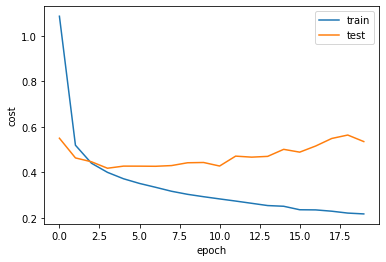

In [7]:
# 绘制cost
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(train_Loss_list, label = "train")
plt.plot(test_Loss_list, label = "test")
plt.legend()
plt.savefig("fashion_mnist_cost_of_train_and_test.png", dpi = 200)

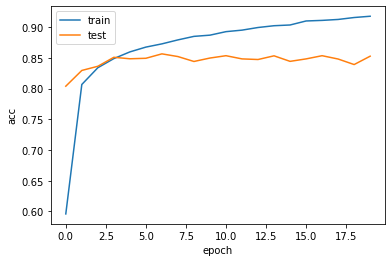

In [8]:
# 绘制acc
plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(train_acc_list, label = "train")
plt.plot(test_acc_list, label = "test")
plt.legend()
plt.savefig("fashion_mnist_acc_of_train_and_test.png", dpi = 200)